## Download Dataset

In [2]:
#https://drive.google.com/file/d/1XXh6awfODaCseZeHN5Xt9ohhTY6WqFuw/view?usp=drive_link
!gdown --id 1XXh6awfODaCseZeHN5Xt9ohhTY6WqFuw

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XXh6awfODaCseZeHN5Xt9ohhTY6WqFuw
From (redirected): https://drive.google.com/uc?id=1XXh6awfODaCseZeHN5Xt9ohhTY6WqFuw&confirm=t&uuid=9c50420b-6e5b-4da8-90bf-7b1d63a803d6
To: /content/vqa_coco_dataset.zip
100% 196M/196M [00:01<00:00, 150MB/s]


In [3]:
!pip install timm
!pip install torchtext==0.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.2 MB/s eta 0:00:00


In [4]:
import os
os.makedirs('vqa_coco_dataset', exist_ok=True)

In [5]:
!unzip -q /content/vqa_coco_dataset.zip -d /content/vqa_coco_dataset

### **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
import torchtext
import os
import numpy as np
import spacy

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchtext.data.utils import get_tokenizer
from torchvision import transforms
from torchtext.vocab import Vocab
from collections import Counter

from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(torch.__version__)
print(torchtext.__version__)

2.5.0+cu121
0.5.0


### **Get Data For Training**

In [ ]:
def get_data(dataset_path):
    data = []
    with open(dataset_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            temp = line.split('\t')
            image_path = temp[0][:-2]
            qa = temp[1].split('?')
            answer = qa[-1].strip()

            data_sample = {
                'image_path': image_path,
                'question': qa[0] + '?',
                'answer': answer
            }
            data.append(data_sample)
    return data

In [ ]:
root_dir = os.getcwd()
train_path = os.path.join(root_dir, 'vqa_coco_dataset', 'vaq2.0.TrainImages.txt')
test_path = os.path.join(root_dir, 'vqa_coco_dataset', 'vaq2.0.TestImages.txt')
val_path = os.path.join(root_dir, 'vqa_coco_dataset', 'vaq2.0.DevImages.txt')

train_data = get_data(train_path)
test_data = get_data(test_path)
val_data = get_data(val_path)

In [ ]:
print(len(train_data))
print(len(test_data))
print(len(val_data))

7846
2022
1952


### **Build Vocabulary**

In [ ]:
eng = spacy.load('en_core_web_sm')

def get_token(data_inter):
    for data in data_inter:
        question = data['question']
        yield [token.text for token in eng.tokenizer(question)]

counter = Counter()

for tokens in get_token(train_data):
    counter.update(tokens)

special_tokens = ['<unk>', '<pad>', '<sos>', '<eos>']
for token in special_tokens:
    counter.update([token])

vocab = Vocab(counter, specials=special_tokens)

In [ ]:
class VocabWrapper:
    def __init__(self, vocab):
        self.vocab = vocab
        self.unk_index = vocab['<unk>']

    def __call__(self, text):
        return self.vocab.stoi.get(text, self.unk_index)

In [ ]:
vocab_wrapper = VocabWrapper(vocab)
def tokenizer(question, max_seq_length=20):
    tokens = [token.text for token in eng.tokenizer(question)]
    tokens = [vocab['<sos>']] + [vocab_wrapper(token) for token in tokens] + [vocab['<eos>']]
    if len(tokens) < max_seq_length:
        tokens.extend(['<pad>'] * (max_seq_length - len(tokens)))
    else:
        tokens = tokens[:max_seq_length]

    return tokens

### **Example of Question Tokenization**

In [ ]:
example_question = train_data[0]['question']
print(f"Question: {example_question}")
print(f"Tokenized Question: {tokenizer(example_question)}")

Question: Is this a creamy soup ?
Tokenized Question: [2, 6, 5, 7, 1168, 575, 4, 3, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


### **Example of Get Image**

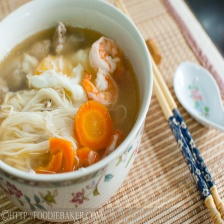

In [ ]:
example_image = Image.open(os.path.join(os.getcwd(), 'vqa_coco_dataset', 'val2014-resised', train_data[0]['image_path']))
example_image

In [ ]:
classes = set([data['answer'] for data in train_data])
classes_to_idx = {
    classes: idx for idx, classes in enumerate(classes)
}
idx_to_classes = {
    idx: classes for classes, idx in classes_to_idx.items()
}

In [ ]:
print(classes_to_idx)
print(idx_to_classes)

{'no': 0, 'yes': 1}
{0: 'no', 1: 'yes'}


### **Create pytorch dataset**

In [ ]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        transforms=None,
        root_dir = os.path.join(os.getcwd(), 'vqa_coco_dataset', 'val2014-resised')
    ):
        self.data = data
        self.classes_to_idx = classes_to_idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.transforms = transforms
        self.device = device
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        image = Image.open(image_path).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        image = np.array(image, dtype=np.float32)
        image = torch.tensor(image)

        if self.img_feature_extractor:
            image = self.img_feature_extractor(image, return_tensors='pt')
            image = {k: v.to(self.device).squeeze(0) for k, v in image.items()}

        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding='max_length',
                max_length=20,
                truncation=True,
                return_tensors='pt'
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}

        answer = self.data[index]['answer']
        answer = torch.tensor(
            classes_to_idx[answer],
            dtype=torch.long
        ).to(self.device)

        sample = {
            'image': image,
            'question': question,
            'answer': answer
        }

        return sample

### **Define Data Transform** 

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(180),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomPerspective(distortion_scale=0.4),
        transforms.GaussianBlur(3)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224))
    ])
}


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


### **Initialize the model**

In [ ]:
image_feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
text_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

### **Create Data Loader**

In [ ]:
train_dataset = VQADataset(
    data=train_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=image_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transforms['train']
)

val_dataset = VQADataset(
    data=val_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=image_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transforms['val']
)

test_dataset = VQADataset(
    data=test_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=image_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transforms['val']
)

In [ ]:
train_batch_size = 1024
test_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

### **Visual Encoder**

In [ ]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained('google/vit-base-patch16-224')

    def forward(self, inputs):
        output = self.model(**inputs)
        return output.pooler_output

### **Text Encoder**

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained('roberta-base')

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output

### **Classifier**

In [ ]:
class Classifier(nn.Module):
    def __init__(
        self,
        input_size = 768*2,
        hidden_size = 512,
        n_layers = 1,
        dropout_prob = 0.2,
        n_classes = len(classes_to_idx)
    ):
        super(Classifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size*2, n_classes)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.dropout(output)
        output = self.fc(output)
        return output

### **VQA Model**

In [ ]:
class VQAModel(nn.Module):
    def __init__(
        self,
        visual_encoder,
        text_encoder,
        classifier
    ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier

    def forward(self, image, question):
        text_encoding = self.text_encoder(question)
        visual_encoding = self.visual_encoder(image)
        combined_encoding = torch.cat((text_encoding, visual_encoding), dim=1)
        output = self.classifier(combined_encoding)
        return output

    def freeze(self, visual_encoder=True, text_encoder=True, classifier=False):
        if visual_encoder:
            for _, param in self.visual_encoder.named_parameters():
                param.requires_grad = False
        if text_encoder:
            for _, param in self.text_encoder.named_parameters():
                param.requires_grad = False
        if classifier:
            for _, param in self.classifier.named_parameters():
                param.requires_grad = False

In [ ]:
n_classes = len(classes_to_idx)
hidden_size = 265
n_layers = 2
dropout_prob = 0.2

In [ ]:
visual_encoder = VisualEncoder().to(device)
text_encoder = TextEncoder().to(device)
classifier = Classifier(
    input_size=768*2,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Evaluation**

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    losses = []
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for sample in data_loader:
            image = sample['image']
            question = sample['question']
            answer = sample['answer']

            output = model(image, question)
            loss = criterion(output, answer)
            losses.append(loss.item())

            _, preds = torch.max(output, 1)
            total_correct += (preds == answer).sum()
            total_samples += answer.size(0)

    avg_loss = sum(losses) / len(losses)
    accuracy = total_correct / total_samples

    return avg_loss, accuracy

### **Training**

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    n_epochs=10
):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        batch_losses = []
        total_correct = 0
        total_samples = 0

        for sample in train_loader:
            image = sample['image']
            question = sample['question']
            answer = sample['answer']

            output = model(image, question)
            loss = criterion(output, answer)
            batch_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(output, 1)
            total_correct += (preds == answer).sum()
            total_samples += answer.size(0)

        batch_train_loss = sum(batch_losses) / len(batch_losses)
        train_losses.append(batch_train_loss)
        train_accuracy = total_correct / total_samples
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch: {epoch+1}/{n_epochs}, Train Loss: {batch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        scheduler.step(val_loss)

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
lr = 1e-3
n_epochs = 20
scheduler_step_size = n_epochs * 0.6
criterion = nn.CrossEntropyLoss()
weight_decay = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
print(device)

cuda


In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    n_epochs=n_epochs
)

Epoch: 1/20, Train Loss: 0.7015, Train Accuracy: 0.4986, Val Loss: 0.6908, Val Accuracy: 0.5359
Epoch: 2/20, Train Loss: 0.6925, Train Accuracy: 0.5189, Val Loss: 0.6923, Val Accuracy: 0.5338
Epoch: 3/20, Train Loss: 0.6914, Train Accuracy: 0.5325, Val Loss: 0.6904, Val Accuracy: 0.5256
Epoch: 4/20, Train Loss: 0.6891, Train Accuracy: 0.5293, Val Loss: 0.6911, Val Accuracy: 0.5343
Epoch: 5/20, Train Loss: 0.6852, Train Accuracy: 0.5515, Val Loss: 0.6895, Val Accuracy: 0.5425
Epoch: 6/20, Train Loss: 0.6810, Train Accuracy: 0.5647, Val Loss: 0.6848, Val Accuracy: 0.5425
Epoch: 7/20, Train Loss: 0.6739, Train Accuracy: 0.5783, Val Loss: 0.6818, Val Accuracy: 0.5543
Epoch: 8/20, Train Loss: 0.6732, Train Accuracy: 0.5846, Val Loss: 0.6794, Val Accuracy: 0.5610
Epoch: 9/20, Train Loss: 0.6636, Train Accuracy: 0.6008, Val Loss: 0.6808, Val Accuracy: 0.5712
Epoch: 10/20, Train Loss: 0.6587, Train Accuracy: 0.6025, Val Loss: 0.6753, Val Accuracy: 0.5743
Epoch: 11/20, Train Loss: 0.6449, Train

In [ ]:
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Validation Loss: 0.7087, Validation Accuracy: 0.6214
Test Loss: 0.7066, Test Accuracy: 0.6316


In [ ]:
torch.save(model.state_dict(), 'model.pth')